In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/LULU.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,77.730003,77.959999,73.349998,74.019997,74.019997,3113800
1,1/3/2013,73.589996,76.050003,73.360001,75.089996,75.089996,1801800
2,1/4/2013,72.349998,72.550003,70.269997,71.949997,71.949997,6142700
3,1/7/2013,71.190002,72.019997,70.099998,71.099998,71.099998,2564400
4,1/8/2013,71.269997,71.669998,70.360001,71.629997,71.629997,2226100


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: 8540.430065.3, cost: -12199.505859, total money: 401.140056
epoch: 20, total rewards: 9696.120018.3, cost: -11119.089844, total money: 593.940018
epoch: 30, total rewards: 9791.470078.3, cost: -15698.763672, total money: 1081.670067
epoch: 40, total rewards: 5870.670048.3, cost: -21765.251953, total money: 4758.780002
epoch: 50, total rewards: 5279.770023.3, cost: -24719.769531, total money: 5717.909992
epoch: 60, total rewards: 5699.670056.3, cost: -24752.037109, total money: 4856.540020
epoch: 70, total rewards: 1043.210068.3, cost: -30631.837891, total money: 10126.580063
epoch: 80, total rewards: 2834.040058.3, cost: -28602.679688, total money: 8071.840061
epoch: 90, total rewards: 2891.780057.3, cost: -28482.623047, total money: 8538.500058
epoch: 100, total rewards: 2252.340069.3, cost: -29043.900391, total money: 8916.190045
epoch: 110, total rewards: 2608.720097.3, cost: -29574.554688, total money: 8458.440083
epoch: 120, total rewards: 3146.580037.3, 

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 4: buy 1 unit at price 71.629997, total balance 9928.370003
day 5, sell 1 unit at price 71.040001, investment -0.823672 %, total balance 9999.410004,
day 7: buy 1 unit at price 70.839996, total balance 9928.570007
day 8: buy 1 unit at price 72.300003, total balance 9856.270004
day 12: buy 1 unit at price 66.800003, total balance 9789.470001
day 13, sell 1 unit at price 66.129997, investment -6.648785 %, total balance 9855.599998,
day 15, sell 1 unit at price 67.599998, investment -6.500698 %, total balance 9923.199997,
day 17: buy 1 unit at price 70.000000, total balance 9853.199997
day 18: buy 1 unit at price 69.830002, total balance 9783.369995
day 19, sell 1 unit at price 69.370003, investment 3.847305 %, total balance 9852.739998,
day 20: buy 1 unit at price 69.000000, total balance 9783.739998
day 21: buy 1 unit at price 67.860001, total balance 9715.879997
day 23, sell 1 unit at price 67.209999, investment -3.985716 %, total balance 9783.089996,
day 24: buy 1 unit at price 68

day 294: buy 1 unit at price 49.880001, total balance 9054.480003
day 295: buy 1 unit at price 49.119999, total balance 9005.360004
day 296: buy 1 unit at price 49.610001, total balance 8955.750004
day 299, sell 1 unit at price 47.130001, investment -5.075529 %, total balance 9002.880005,
day 300: buy 1 unit at price 46.779999, total balance 8956.100006
day 301, sell 1 unit at price 46.779999, investment -4.119701 %, total balance 9002.880005,
day 302, sell 1 unit at price 48.040001, investment 0.397079 %, total balance 9050.920006,
day 303: buy 1 unit at price 49.009998, total balance 9001.910007
day 305: buy 1 unit at price 48.740002, total balance 8953.170006
day 306: buy 1 unit at price 47.630001, total balance 8905.540005
day 307: buy 1 unit at price 49.320000, total balance 8856.220005
day 308: buy 1 unit at price 47.990002, total balance 8808.230003
day 309, sell 1 unit at price 48.230000, investment 2.290558 %, total balance 8856.460003,
day 310: buy 1 unit at price 51.200001, 

day 587, sell 1 unit at price 64.760002, investment -3.472938 %, total balance 8907.279995,
day 588: buy 1 unit at price 64.309998, total balance 8842.969997
day 589: buy 1 unit at price 65.040001, total balance 8777.929996
day 592: buy 1 unit at price 65.669998, total balance 8712.259998
day 593: buy 1 unit at price 64.699997, total balance 8647.560001
day 594, sell 1 unit at price 64.410004, investment -0.678481 %, total balance 8711.970005,
day 595, sell 1 unit at price 65.199997, investment 4.654892 %, total balance 8777.170002,
day 596: buy 1 unit at price 64.489998, total balance 8712.680004
day 597: buy 1 unit at price 64.580002, total balance 8648.100002
day 598, sell 1 unit at price 63.000000, investment 1.221077 %, total balance 8711.100002,
day 599, sell 1 unit at price 61.910000, investment -0.578128 %, total balance 8773.010002,
day 601: buy 1 unit at price 61.160000, total balance 8711.850002
day 602, sell 1 unit at price 60.270000, investment -4.059216 %, total balance 8

day 749: buy 1 unit at price 53.150002, total balance 8260.930004
day 750, sell 1 unit at price 52.889999, investment -19.729853 %, total balance 8313.820003,
day 753: buy 1 unit at price 52.369999, total balance 8261.450005
day 755: buy 1 unit at price 52.470001, total balance 8208.980003
day 756, sell 1 unit at price 55.860001, investment -12.786888 %, total balance 8264.840004,
day 758, sell 1 unit at price 54.910000, investment 2.885518 %, total balance 8319.750004,
day 759, sell 1 unit at price 54.790001, investment 0.256175 %, total balance 8374.540005,
day 760, sell 1 unit at price 53.910000, investment 1.890002 %, total balance 8428.450005,
day 761: buy 1 unit at price 54.730000, total balance 8373.720005
day 763: buy 1 unit at price 55.970001, total balance 8317.750004
day 764, sell 1 unit at price 56.630001, investment 13.692029 %, total balance 8374.380005,
day 765: buy 1 unit at price 55.709999, total balance 8318.670006
day 766: buy 1 unit at price 56.740002, total balance

day 925, sell 1 unit at price 68.570000, investment -0.623189 %, total balance 8712.250000,
day 926, sell 1 unit at price 67.680000, investment -5.540825 %, total balance 8779.930000,
day 927: buy 1 unit at price 68.230003, total balance 8711.699997
day 928, sell 1 unit at price 66.080002, investment -10.654404 %, total balance 8777.779999,
day 929: buy 1 unit at price 64.800003, total balance 8712.979996
day 931, sell 1 unit at price 65.930000, investment -13.805723 %, total balance 8778.909996,
day 933, sell 1 unit at price 66.050003, investment -15.048228 %, total balance 8844.959999,
day 936: buy 1 unit at price 65.690002, total balance 8779.269997
day 937: buy 1 unit at price 65.400002, total balance 8713.869995
day 939, sell 1 unit at price 65.190002, investment -15.535110 %, total balance 8779.059998,
day 940: buy 1 unit at price 64.029999, total balance 8715.029999
day 941, sell 1 unit at price 64.519997, investment -16.619283 %, total balance 8779.549995,
day 942, sell 1 unit 

day 1072: buy 1 unit at price 49.430000, total balance 9405.959995
day 1074, sell 1 unit at price 50.630001, investment -19.736843 %, total balance 9456.589996,
day 1075, sell 1 unit at price 52.259998, investment -18.483859 %, total balance 9508.849995,
day 1077, sell 1 unit at price 52.080002, investment -18.216078 %, total balance 9560.929997,
day 1078: buy 1 unit at price 51.220001, total balance 9509.709995
day 1079, sell 1 unit at price 52.000000, investment 5.199271 %, total balance 9561.709995,
day 1080: buy 1 unit at price 51.930000, total balance 9509.779995
day 1081: buy 1 unit at price 52.200001, total balance 9457.579994
day 1085, sell 1 unit at price 52.459999, investment 2.420925 %, total balance 9510.039993,
day 1087: buy 1 unit at price 52.770000, total balance 9457.269993
day 1090, sell 1 unit at price 52.459999, investment 1.020602 %, total balance 9509.729992,
day 1091: buy 1 unit at price 52.209999, total balance 9457.519993
day 1093, sell 1 unit at price 51.950001

day 1266: buy 1 unit at price 78.989998, total balance 9125.629990
day 1267: buy 1 unit at price 78.839996, total balance 9046.789993
day 1268: buy 1 unit at price 76.699997, total balance 8970.089996
day 1269, sell 1 unit at price 77.919998, investment 4.858028 %, total balance 9048.009994,
day 1270: buy 1 unit at price 77.570000, total balance 8970.439995
day 1271, sell 1 unit at price 79.339996, investment 6.941628 %, total balance 9049.779991,
day 1272: buy 1 unit at price 78.959999, total balance 8970.819992
day 1274, sell 1 unit at price 79.199997, investment 3.017690 %, total balance 9050.019989,
day 1276: buy 1 unit at price 79.080002, total balance 8970.939987
day 1277: buy 1 unit at price 79.959999, total balance 8890.979988
day 1278: buy 1 unit at price 79.480003, total balance 8811.499985
day 1280: buy 1 unit at price 78.809998, total balance 8732.689987
day 1281, sell 1 unit at price 78.620003, investment -0.832487 %, total balance 8811.309990,
day 1284: buy 1 unit at pric

day 1473, sell 1 unit at price 141.130005, investment 2.692289 %, total balance 9594.050026,
day 1475: buy 1 unit at price 142.270004, total balance 9451.780022
day 1476: buy 1 unit at price 137.559998, total balance 9314.220024
day 1477, sell 1 unit at price 135.419998, investment 0.841466 %, total balance 9449.640022,
day 1478, sell 1 unit at price 138.699997, investment 2.075355 %, total balance 9588.340019,
day 1480: buy 1 unit at price 139.830002, total balance 9448.510017
day 1483: buy 1 unit at price 121.389999, total balance 9327.120018
day 1485, sell 1 unit at price 120.860001, investment -14.965175 %, total balance 9447.980019,
day 1486: buy 1 unit at price 123.760002, total balance 9324.220016
day 1487: buy 1 unit at price 122.769997, total balance 9201.450020
day 1488: buy 1 unit at price 128.990005, total balance 9072.460014
day 1489, sell 1 unit at price 129.460007, investment -10.203227 %, total balance 9201.920021,
day 1490, sell 1 unit at price 132.550003, investment -

day 1649, sell 1 unit at price 189.070007, investment 6.994511 %, total balance 9657.330009,
day 1650, sell 1 unit at price 192.210007, investment 2.731160 %, total balance 9849.540016,
day 1652, sell 1 unit at price 190.610001, investment 5.829771 %, total balance 10040.150016,
day 1653, sell 1 unit at price 192.089996, investment 6.592303 %, total balance 10232.240013,
day 1654: buy 1 unit at price 191.770004, total balance 10040.470008
day 1655: buy 1 unit at price 191.089996, total balance 9849.380012
day 1656: buy 1 unit at price 185.449997, total balance 9663.930015
day 1657: buy 1 unit at price 178.929993, total balance 9485.000023
day 1658, sell 1 unit at price 174.460007, investment -6.229506 %, total balance 9659.460029,
day 1659, sell 1 unit at price 179.630005, investment -2.305972 %, total balance 9839.090034,
day 1660, sell 1 unit at price 181.360001, investment -0.934073 %, total balance 10020.450035,
day 1661, sell 1 unit at price 186.350006, investment -2.013875 %, tot

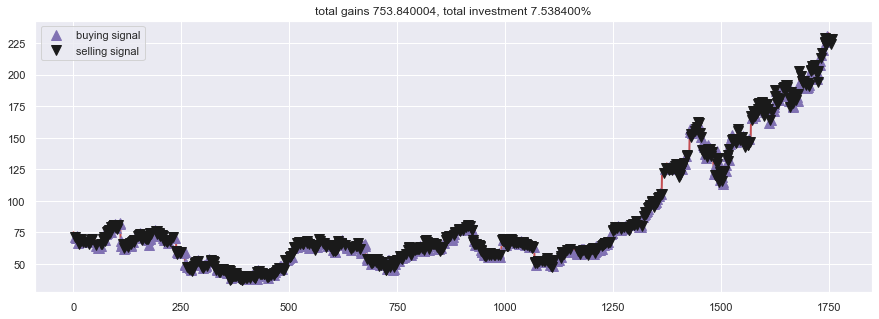

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()